### Let’s Import the Essentials Libraries

In [394]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

### Setting Up Device Agnostic Code
Here, we check if we’ve got a GPU available. If yes, awesome computations will run faster. If not, no worries, we’ll just stick with the CPU.

In [395]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Making Some Dummy Data
We’re not using real-world data here, but that’s totally fine! We’re generating synthetic “circular” data just to test our models. Here there are 2 classes.

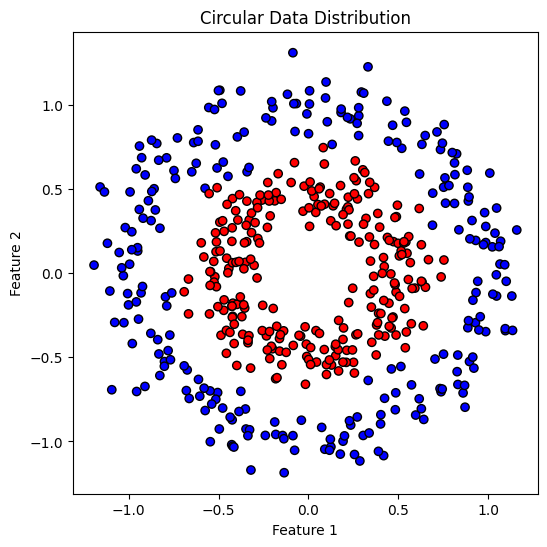

In [396]:
from sklearn.datasets import make_circles

# Generate circular data
X, y = make_circles(n_samples=500, noise=0.1, factor=0.5, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

# Plot the data
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap='bwr', edgecolor='k')
plt.title("Circular Data Distribution")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### Splitting the Data – Train and Test

In [397]:
# train test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Defining the Linear Model
This is our basic model with a couple of layers and sigmoid activation functions.

In [ ]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 5)  # 2 input features, hidden units
        self.hidden = nn.Linear(5, 2)  # 5 input features, 2 hidden units
        self.fc2 = nn.Linear(2, 1)  # 2 hidden units, 1 output

    def forward(self,x):
        x = self.fc1(x)
        x = self.hidden(x)
        return torch.sigmoid(self.fc2(x))

### Defining the Non-Linear Model
This model has ReLU activation functions, giving it more power to capture non-linear patterns.

In [ ]:
class NonLinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 5)   # Input → hidden
        self.hidden = nn.Linear(5, 2)  # Hidden → hidden
        self.fc2 = nn.Linear(2, 1)    # Hidden → output
        self.relu = nn.ReLU()         # Single activation layer reused

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.hidden(x)
        x = self.relu(x)
        x = self.fc2(x)
        return torch.sigmoid(x)


In [400]:
# initialize both the models
linear_model = LinearModel().to(device)
nonlinear_model = NonLinearModel().to(device)

### Train and Test Function
In the **train fcuntion** define how the model learns from the data – calculating loss, making predictions, and adjusting weights using gradients. It’s like giving feedback after each attempt!

In the **test function** tests the model’s performance on unseen data.

In [401]:
# Training Function
def train(model,X_train,y_train, loss_fn, optimizer,acc):
    X_train, y_train = X_train.to(device), y_train.to(device)
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    preds = (y_pred > 0.5).int()
    accuracy = acc(preds, y_train.int())
    loss.backward()
    optimizer.step()
    return loss.item(), accuracy

In [402]:
# Testing Function
def test(model,X_test, y_test, loss_fn, acc):
    X_test, y_test = X_test.to(device), y_test.to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        loss = loss_fn(y_pred, y_test)
        preds = (y_pred > 0.5).int()
        accuracy = acc(preds, y_test.int())
    return loss.item(), accuracy

### Loss and Optimizer
We pick binary cross-entropy as our loss function because this is a binary classification problem. Adam optimizer helps the model learn more efficiently. We could use any optimizer like Stochastic Gradeint Descent or Momentum Based Gradeient Descent

In [403]:
criterion = nn.BCELoss()
linear_optimizer = optim.Adam(linear_model.parameters(), lr=0.01)
nonlinear_optimizer = optim.Adam(nonlinear_model.parameters(), lr=0.01)

### Training Loop
This is where both models go through multiple rounds (epochs) of training. Every 50 steps, we check how well they’re doing on test data.

In [404]:
import torch
from torchmetrics.classification import Accuracy

# Initialize Accuracy metrics for both models
linear_acc = Accuracy(task="binary")
nonlinear_acc = Accuracy(task="binary")

num_epochs = 150

for epoch in range(1, num_epochs + 1):
    # Training step for Linear Model
    linear_train_loss, linear_train_acc = train(linear_model,X_train, y_train, criterion, linear_optimizer, linear_acc)
    linear_acc.reset()

    # Training step for Nonlinear Model
    nonlinear_train_loss, nonlinear_train_acc = train(nonlinear_model,X_train, y_train, criterion, nonlinear_optimizer, nonlinear_acc)
    nonlinear_acc.reset()

    # Testing every 50 epochs
    if epoch % 50 == 0:
        # Test Linear Model
        linear_test_loss, linear_test_acc = test(linear_model, X_test, y_test, criterion, linear_acc)
        linear_acc.reset()

        # Test Nonlinear Model
        nonlinear_test_loss, nonlinear_test_acc = test(nonlinear_model, X_test, y_test, criterion, nonlinear_acc)
        nonlinear_acc.reset()

        print(f"Epoch {epoch}/{num_epochs}")
        print(f"Linear Model -> Train Loss: {linear_train_loss:.4f}, Train Accuracy: {linear_train_acc:.4f}")
        print(f"Linear Model -> Test Loss: {linear_test_loss:.4f}, Test Accuracy: {linear_test_acc:.4f}")
        
        print(f"Nonlinear Model -> Train Loss: {nonlinear_train_loss:.4f}, Train Accuracy: {nonlinear_train_acc:.4f}")
        print(f"Nonlinear Model -> Test Loss: {nonlinear_test_loss:.4f}, Test Accuracy: {nonlinear_test_acc:.4f}")
        print("-------------------------------")


Epoch 50/150
Linear Model -> Train Loss: 0.6927, Train Accuracy: 0.4925
Linear Model -> Test Loss: 0.6967, Test Accuracy: 0.4200
Nonlinear Model -> Train Loss: 0.6175, Train Accuracy: 0.6100
Nonlinear Model -> Test Loss: 0.6415, Test Accuracy: 0.5800
-------------------------------
Epoch 100/150
Linear Model -> Train Loss: 0.6927, Train Accuracy: 0.4400
Linear Model -> Test Loss: 0.6971, Test Accuracy: 0.3900
Nonlinear Model -> Train Loss: 0.4151, Train Accuracy: 0.8750
Nonlinear Model -> Test Loss: 0.4450, Test Accuracy: 0.8200
-------------------------------
Epoch 150/150
Linear Model -> Train Loss: 0.6927, Train Accuracy: 0.4350
Linear Model -> Test Loss: 0.6971, Test Accuracy: 0.3800
Nonlinear Model -> Train Loss: 0.1636, Train Accuracy: 0.9825
Nonlinear Model -> Test Loss: 0.2039, Test Accuracy: 0.9400
-------------------------------


### Evaluating the model

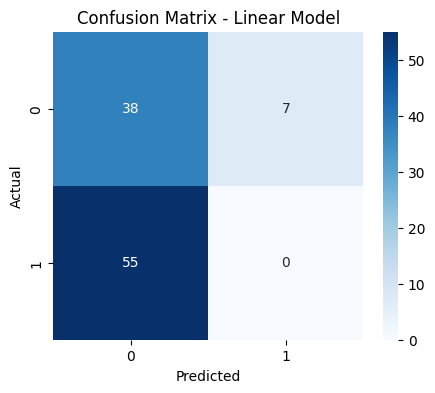

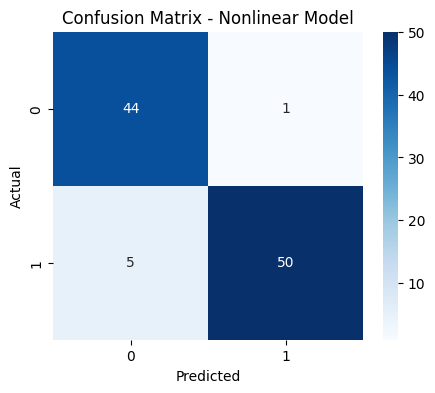

In [405]:
from torchmetrics.classification import ConfusionMatrix
import seaborn as sns

# Initialize confusion matrix for binary classification
confmat = ConfusionMatrix(task="binary")

# Make predictions
linear_model.eval()
nonlinear_model.eval()
with torch.inference_mode():
    linear_preds = linear_model(X_test)
    nonlinear_preds = nonlinear_model(X_test)
linear_preds = (linear_preds > 0.5).int()
nonlinear_preds = (nonlinear_preds > 0.5).int()
targets = y_test.int()
linear_cm = confmat(linear_preds, targets)
nonlinear_cm = confmat(nonlinear_preds, targets)

# Plotting function
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm.cpu().numpy(), annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Plot for Linear Model
plot_confusion_matrix(linear_cm, "Confusion Matrix - Linear Model")

# Plot for Nonlinear Model
plot_confusion_matrix(nonlinear_cm, "Confusion Matrix - Nonlinear Model")


### Decision Boundaries

This is the fun part! We draw the regions where the model thinks one class ends and another begins. It’s like tracing the model’s thought process, neat, isn’t it?

In [406]:
def plot_decision_boundary(model, title):
    model.eval()
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
    with torch.inference_mode():
        preds = model(grid).reshape(xx.shape).cpu().numpy()
    plt.contourf(xx, yy, preds, levels=[0, 0.5, 1], cmap='bwr', alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap='bwr', edgecolor='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


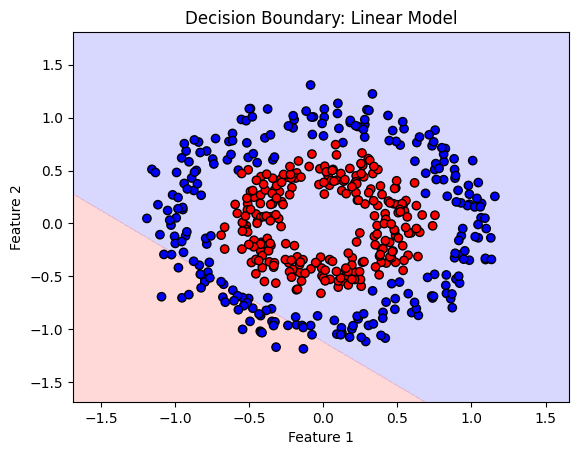

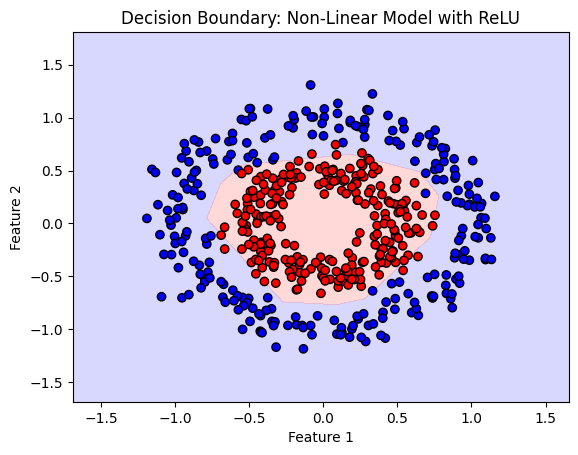

In [407]:
plot_decision_boundary(linear_model, "Decision Boundary: Linear Model")
plot_decision_boundary(nonlinear_model, "Decision Boundary: Non-Linear Model with ReLU")